## Expansion modification system - 2 bases

### DNA Sequence generation

In [93]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.sparse import csr_matrix
import subprocess
import numpy as np
from Bio import SeqIO

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional

from sklearn.metrics import confusion_matrix
import itertools

In [2]:
def DNA_gen(N0, N, Pmut, g, M = 0):
    print('Pmut: ', Pmut)
    DNA = list(np.random.randint(0,2, size = N0)) 
    limit = [0,g,1]
    base = [1,0]
    print(limit)
    while (len(DNA) != N):
        j = np.random.randint(0,len(DNA))
        nuc = DNA[j]
        p = np.random.random()
        if(p>Pmut):
            DNA.insert(j+1, nuc)
        else:
            if(False):
                pg = np.random.random()
                v = np.array(limit)-pg
                v[v<0] = 1
                idx = np.argmin(v)
                DNA[j] = base[idx-1]
            if(nuc==1):
                DNA[j] = 0
            else: DNA[j] = 1
    count = 0
    while(count != M):
        j = np.random.randint(0,len(DNA))
        pg = np.random.random()
        v = np.array(limit)-pg
        v[v<0] = 1
        idx = np.argmin(v)
        DNA[j] = base[idx-1]
        count += 1

    return DNA

In [4]:
def Corr(s,r,alphabet):
    bases = ['A','C']
    C = 0
    freq = 0
    s1 = s[:-r]
    s2 = s[r:]
    long_dist = np.equal(s1,s2)
    long_dist = np.sum([int(long_dist[i]) for i in range(len(long_dist))])/len(long_dist)
    for i in bases:
        freq += (alphabet[i][0]/len(s))**2
    C = long_dist -freq
    return C

In [5]:
def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth
def scaling(x,a,c):
    return c*x**(-a)

### Sequence Generation

In [6]:
N = 5000000
N0 = 1

print('**Human**')
human2 = DNA_gen(N0,N,0.10,0.4, M = int(N/3))

print('**Neanderthal**')
neanderthal2 = DNA_gen(N0,N,0.12,0.4, M = int(N/6))

**Human**
Pmut:  0.1
[0, 0.4, 1]
**Neanderthal**
Pmut:  0.12
[0, 0.4, 1]


In [7]:
change = {0:['A'], 1:['C']}
N_DNA2 = []
H_DNA2 = []
for i in range(N):
    N_DNA2.append(change[human2[i]][0])
    H_DNA2.append(change[neanderthal2[i]][0])

In [8]:
human_alphabet2 = {'A':[0], 'C':[0]}
neanderthal_alphabet2 = {'A':[0], 'C':[0]}
for (i,j) in zip(H_DNA2,N_DNA2):
    human_alphabet2[i][0] += 1
    neanderthal_alphabet2[j][0] += 1
    
print('**Human**')
print(human_alphabet2)
print('GC-content: ',(human_alphabet2['C'][0]#+human_alphabet['G'][0]
                     )/len(H_DNA2))

print('**Neanderthal**')
print(neanderthal_alphabet2)
print('GC-content: ',(neanderthal_alphabet2['C'][0]
                      #+neanderthal_alphabet['G'][0]
                     )/len(N_DNA2))

**Human**
{'A': [2482016], 'C': [2517984]}
GC-content:  0.5035968
**Neanderthal**
{'A': [2618255], 'C': [2381745]}
GC-content:  0.476349


C[H]: 0.2272081990841874
G[H]: 0.43267001061430865
C[N]: 0.34988264488625825
G[N]: 0.5832441197389489


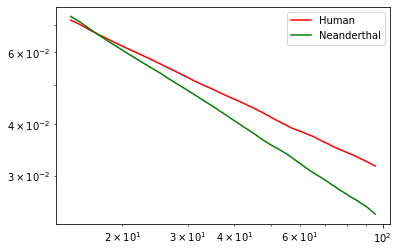

In [108]:
r = np.linspace(10,100,100)
n = 5
m = 5

cr_H2 = [Corr(human2,int(ri),human_alphabet2) for ri in r]
cr_H2 = smooth(cr_H2,10)

cr_N2 = [Corr(neanderthal2,int(ri),neanderthal_alphabet2) for ri in r]
cr_N2 = smooth(cr_N2,10)
 

gamma_H2 = scipy.optimize.curve_fit(scaling,r[n:-m],cr_H2[n:-m])[0]
gamma_N2 = scipy.optimize.curve_fit(scaling,r[n:-m],cr_N2[n:-m])[0]
        
plt.plot(r[n:-m],cr_H2[n:-m], c = 'red', label = 'Human')
#plt.plot(r[n:-m],scaling(r[n:-m],gamma_H2[0],gamma_H2[1]), c = 'black')

plt.plot(r[n:-m],cr_N2[n:-m], c = 'green', label = 'Neanderthal')
#plt.plot(r[n:-m],scaling(r[n:-m],gamma_N2[0],gamma_N2[1]), c = 'black')

print('C[H]:',gamma_H2[1])
print('G[H]:',gamma_H2[0])

print('C[N]:',gamma_N2[1])
print('G[N]:',gamma_N2[0])

plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

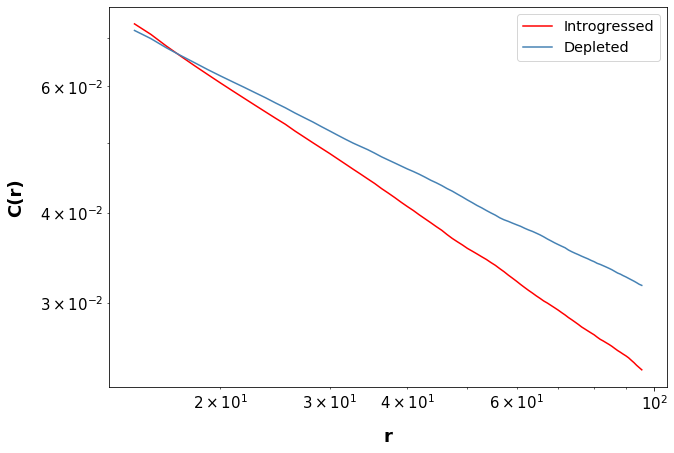

In [121]:
plt.figure(figsize = (10,7))
plt.plot(r[n:-m],cr_N2[n:-m], '-', color = 'red', markersize = 10, label = 'Introgressed')
plt.plot(r[n:-m],cr_H2[n:-m], '-', color = 'steelblue', markersize = 10, label = 'Depleted')
plt.xlabel('r', fontsize = 18, labelpad = 15, weight = 'semibold')
plt.ylabel('C(r)', fontsize = 18, labelpad = 15, weight = 'semibold')
plt.yscale('log')
plt.xscale('log')
plt.tick_params(labelsize=15,  which='both')
plt.legend(fontsize = 'x-large')
plt.show()

### Write DNA Sequence

In [10]:
string = ''
with open('human.txt', mode='w') as f:
    f.write(string.join(H_DNA2))
    f.close()
string = ''
with open('neanderthal.txt', mode='w') as f:
    f.write(string.join(N_DNA2))
    f.close()

### Divide in Sentences and then in KMers

In [46]:
with open('human.txt', mode='r') as f:
    H_DNA = f.read().rstrip('\n')
    f.close()
with open('neanderthal.txt', mode='r') as f:
    N_DNA = f.read().rstrip('\n')
    f.close()

In [47]:
H_DNA = [i for i in H_DNA]
N_DNA = [i for i in N_DNA]

In [86]:
sentence_length= 200 

H_DNA = np.array(H_DNA[0:(len(H_DNA)//sentence_length)*sentence_length])
N_DNA = np.array(N_DNA[0:(len(N_DNA)//sentence_length)*sentence_length])

#divide in sentences
H_DNA_s= np.array(np.split(H_DNA, len(H_DNA)//sentence_length))
N_DNA_s= np.array(np.split(N_DNA, len(N_DNA)//sentence_length))

H_DNA_s = [''.join(i) for i in H_DNA_s]
N_DNA_s = [''.join(i) for i in N_DNA_s]

In [89]:
def getKmers(sequence, size):
    return [sequence[x:x+size] for x in range(len(sequence) - size + 1)]

kmer = [10]
for k in kmer:
    print('KMER: ', k)
    intr_texts = [' '.join(map(str, (getKmers(i, k)))) for i in N_DNA_s]
    depl_texts = [' '.join(map(str, (getKmers(i, k)))) for i in H_DNA_s]

KMER:  10


In [90]:
merge_texts = intr_texts + depl_texts

tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)
#X = tokenizer.texts_to_matrix(merge_texts, mode = 'freq')

encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(X))
print(len(labels))
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

50000
50000


In [96]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

1025

In [97]:
X_train[0]

array([491, 457, 260, 264, 455, 408, 182, 370, 180, 399, 613, 549, 229,
       214, 175,  70,  10,   7,  42,   8,   9,  12,  14,  13,  11,  10,
         7,   3,   1,   1,   1,   4,   8,  55, 102, 116, 126, 125, 115,
       103,  53,   7,   3,   1,   4,  24,  37,  43,  45,  49,  48,  44,
        38,  23,   3,   1,   1,   4,   8,   9,  12,  14,  13,  78, 184,
       224, 158,  36,  34,  30,  26,  39,  16,  18,  20,  21,  22,  19,
        63,  87,  64,  59, 164, 275, 619, 768, 789, 666, 263, 247, 120,
       246,  87,  64,  59, 164, 275, 619, 695, 958, 888, 909, 969, 703,
       625, 267, 162,  60,  17,  15,   5,   2,   2,   2,   2,   2,   2,
         2,   2,   2,   2,   2,   6,  16,  56,  84,  89,  90,  91, 334,
       423, 308,  99,  68,  22,  19,  17,  15,  39,  16,  56,  84,  89,
       333, 576, 812, 831, 688, 287, 226,  46,  41,  26,   5,   2,   2,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,
         6,  16,  18,  59, 164, 197, 427, 519, 513, 724, 523, 45

In [101]:
d = 10
model = Sequential()
model.add(Embedding(vocab_size, d)) #dropout = 0.2 #input_length = max_length
model.add(Bidirectional(LSTM(int(d/2)))) #dropout = 0.2, recurrent_dropout = 0.2
model.add(Dense(d, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
#checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
#                             save_best_only = True, mode = 'max')

print(model.summary())

history = model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 2, validation_split = 0.2, batch_size = 32, shuffle = True, 
#                    callbacks = [checkpoint]
                   )

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

scores = model.evaluate(X_test, y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 10)          10250     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 10)                640       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 11        
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________
None
Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 - 36s - loss: 0.5759 - accuracy: 0.7017 - val_loss: 0.5158 - val_accuracy: 0.7477
Epoch 2/5
32000/32000 - 31s - loss: 0.5094 - accuracy: 0.7579 - val_loss: 0.5250 - val_acc

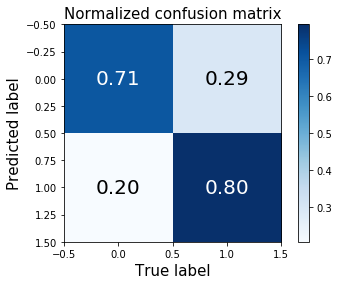

In [102]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 15)
plt.colorbar()
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()

In [104]:
sentence_length= 200
word_length = 10

H_DNA = np.array(H_DNA[0:(len(H_DNA)//sentence_length)*sentence_length])
N_DNA = np.array(N_DNA[0:(len(N_DNA)//sentence_length)*sentence_length])

#divide in sentences
H_DNA_s = np.array(np.split(H_DNA, len(H_DNA)//sentence_length))
N_DNA_s = np.array(np.split(N_DNA, len(N_DNA)//sentence_length))

#divide in words
H_DNA_w = np.array(np.split(H_DNA_s, sentence_length//word_length, axis=1  ))
N_DNA_w = np.array(np.split(N_DNA_s, sentence_length//word_length , axis=1 ))

print(H_DNA_w.shape)
print(N_DNA_w.shape)
print("words,sentences,letters")

#make words strings.
Human_DNA = np.array([[''.join(H_DNA_w[i,j]) for i in range(H_DNA_w.shape[0]) ]for 
                  j in range(H_DNA_w.shape[1])])
#make words strings.
Neanderthal_DNA = np.array([[''.join(N_DNA_w[i,j]) for i in range(N_DNA_w.shape[0]) ]for 
                  j in range(N_DNA_w.shape[1])])

depl_texts = [' '.join(Human_DNA[i,:]) for i in range(Human_DNA.shape[0])]
intr_texts = [' '.join(Neanderthal_DNA[i,:]) for i in range(Neanderthal_DNA.shape[0])]

merge_texts = intr_texts + depl_texts
print(len(merge_texts))
labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)

encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, shuffle = True)

print(X_train.shape)
print(X_test.shape)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

(20, 25000, 10)
(20, 25000, 10)
words,sentences,letters
50000
50000
(40000, 20)
(10000, 20)
1025


In [106]:
model.fit(X_train, y_train, 
                    epochs = epochs, verbose = 2, validation_split = 0.2, shuffle = True)

Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 - 13s - loss: 0.5304 - accuracy: 0.7367 - val_loss: 0.5189 - val_accuracy: 0.7419
Epoch 2/5
32000/32000 - 9s - loss: 0.4952 - accuracy: 0.7592 - val_loss: 0.5150 - val_accuracy: 0.7441
Epoch 3/5
32000/32000 - 9s - loss: 0.4875 - accuracy: 0.7629 - val_loss: 0.5240 - val_accuracy: 0.7473
Epoch 4/5
32000/32000 - 9s - loss: 0.4822 - accuracy: 0.7689 - val_loss: 0.5150 - val_accuracy: 0.7477
Epoch 5/5
32000/32000 - 8s - loss: 0.4791 - accuracy: 0.7688 - val_loss: 0.5129 - val_accuracy: 0.7429


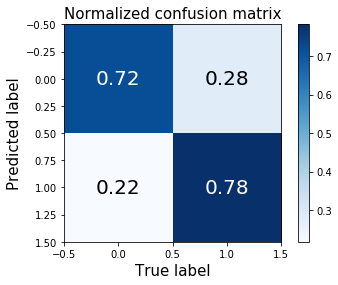

In [107]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

predicted_labels = model.predict(X_test)
cm = confusion_matrix(y_test, [np.round(i[0]) for i in predicted_labels])
cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

plt.imshow(cm, cmap = plt.cm.Blues)
plt.title('Normalized confusion matrix', fontsize = 15)
plt.colorbar()
plt.xlabel('True label', fontsize = 15)
plt.ylabel('Predicted label', fontsize = 15)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment = 'center', verticalalignment = 'center', fontsize = 20,
             color='white' if cm[i, j] > 0.5 else 'black')
plt.show()